In [1211]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
from scipy.constants import hbar, m_e
import vegas

# Path Integral Approach to the Quantum Harmonic Oscillator

In [1212]:
# add root folder to path
import sys
sys.path.append('../')

from utility import plots
plots.set_style()

In [1213]:
# simulation parameters
a = 0.5
N = 8 # slices of configuration space
m = 1 # mass of particle
A = (m/(2 * np.pi * a))**(N/2) # normalization constant

In [1214]:
# descretization of the time interval and therefore path
T = N * a
T

4.0

In [1215]:
def QHOPotential(x_eval): # potential function
    return x_eval**2/2

In [1216]:
def calcAction(x_grid, potential, x):
    action = 0
    # Sum action over the range from 0 to N-1
    for i in range(N):
        kinetic = m * (x_grid[i + 1] - x_grid[i]) ** 2 / (2 * a)
        potential_energy = a * potential(x_grid[i])
        action += kinetic + potential_energy

    return action


In [1217]:
def pathIntegralIntegrand(x_vals, potential, x):
    # Add the boundary conditions (x_0 = x_N = x)
    x_full = np.concatenate(([x], x_vals, [x]))
    return np.exp(-calcAction(x_full, potential, x))

# This function computes the path integral using vegas
def calcPathIntegral(potential, x):
    # Define the limits for N-1 [x_1, x_N-1] variables
    limits = [[-5, 5]] * (N - 1)
    # Initialize the vegas Integrator
    integ = vegas.Integrator(limits)
    
    # Define the integrand for vegas, which takes a single argument
    def vegas_integrand(x_vals):
        return pathIntegralIntegrand(x_vals, potential, x)
    
    # Warm-up the integrator
    integ(vegas_integrand, nitn=30, neval=1000)
    
    # Compute the integral
    result = integ(vegas_integrand, nitn=10, neval=10000)
    
    # Multiply by the normalization constant
    return A * result.mean, A * result.sdev


In [1218]:
calcPathIntegral(QHOPotential, 0)

(0.07744966662047988, 0.00044431903885661886)

In [1219]:
# calc the propagator for grid of x values
x_bins = np.arange(0, 2, 0.1)
EHO_propagator = [calcPathIntegral(QHOPotential, x) for x in x_bins]
EHO_propagator = np.array([[x[0] for x in EHO_propagator], [x[1] for x in EHO_propagator]])

In [1220]:
# define the exact propagator
def exactEHOPropagator(x):
    E_0 = 1/2
    bra_x_ket_E_0 = np.exp(-x**2/2) / np.pi**(1/4)
    return bra_x_ket_E_0**2 * np.exp(-E_0 * T)

In [1221]:
exact_EHO_propagator = exactEHOPropagator(x_grid)

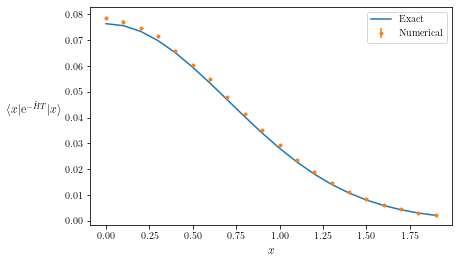

In [1222]:
# plot the results
fig, ax = plt.subplots(figsize=plots.set_size('default', fraction=1))

ax.plot(x_grid, exact_EHO_propagator, label='Exact')
ax.errorbar(x_grid, EHO_propagator[0], fmt = 'o', ms = 3, yerr=EHO_propagator[1], label='Numerical')
ax.legend()

ax.set_ylabel(r'$\langle{x}|{\textrm{e}^{-\hat{H} T}}|{x}\rangle$', rotation=0, labelpad=30)
ax.set_xlabel(r'$x$')
plt.savefig('QHOPathIntegral.pdf', bbox_inches='tight')